# Stock Volatility Model using the Ornstein-Uhlenbeck Process

In [9]:
import time 
import math
import numpy as np 
import pandas as pd 
import datetime 
import scipy as sc
import matplotlib.pyplot as plt 
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yahooFinance

In [21]:
# Importing Data form S&P 500: GSPC
def get_data(stocks, source, start, end):
    df = pdr.DataReader(stocks, source, start, end)
    return df

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)

stock_prices = get_data('AAPL', 'stooq', startDate, endDate)
print(startDate)
stock_prices.head()

2005-07-23 21:37:13.731086


,Open,High,Low,Close,Volume
Date,,,,,
2024-09-20,229.97,233.09,227.62,228.20,318679888.0
2024-09-19,224.99,229.82,224.63,228.87,66781315.0
2024-09-18,217.55,222.71,217.54,220.69,59894928.0
2024-09-17,215.75,216.90,214.50,216.79,45519339.0
2024-09-16,216.54,217.22,213.92,216.32,59357427.0


## Volatility Clustering
$r_{t} = X_{t+\Delta} - X_{t} = ln(S_{t} + \Delta S_{t})$

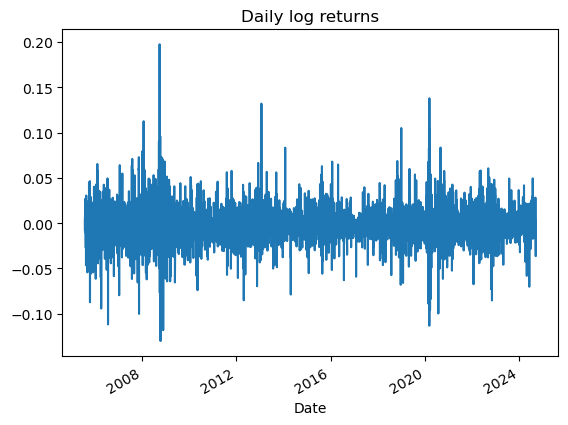

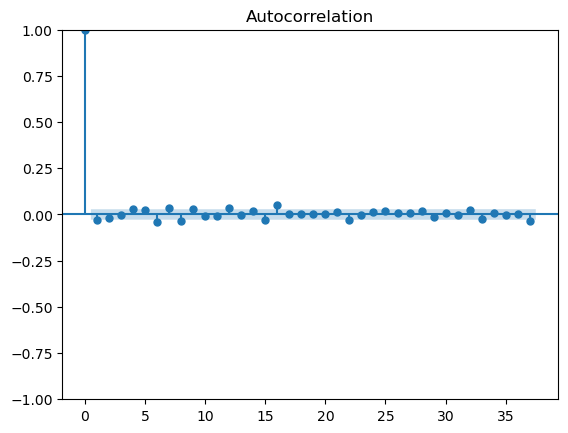

In [22]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title("Daily log returns")
plot_acf(log_returns)
plt.show()

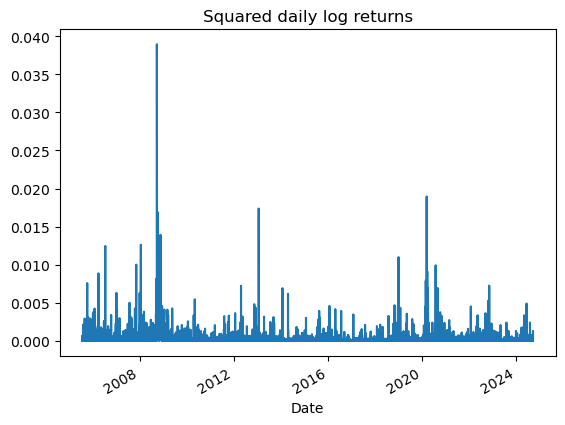

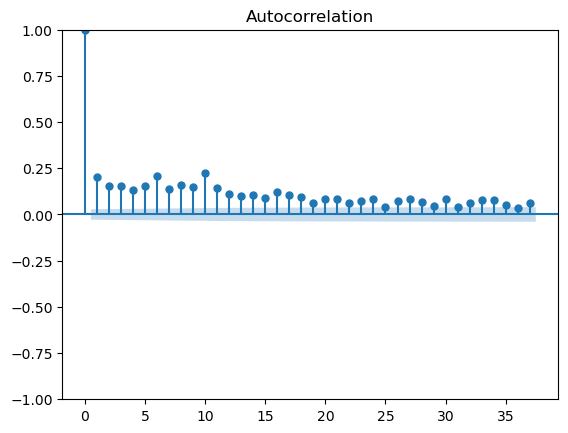

In [24]:
log_returns_sq = np.square(np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna())
log_returns_sq.plot()
plt.title('Squared daily log returns')
plot_acf(log_returns_sq)
plt.show()

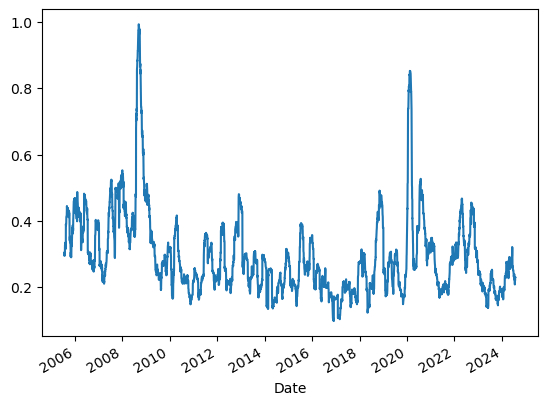

In [25]:
trading_days = 40
volatility = log_returns.rolling(window=trading_days).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.show()

## Maximum Likelihood Estimator (MLE)

In [26]:
def MLE_norm(X):
    mu_hat = np.mean(X)
    sigma2_hat = np.var(X)
    return mu_hat, sigma2_hat

In [30]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = '$\hat{\mu} = '+format(round(mu_hat, 2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat), 2))+'$'

print("The MLE for data is: ")
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is: 


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Performing MLE numerically

In [32]:
def log_likelihood(theta, x): 
    mu = theta[0]
    sigma = theta[1]
    
    theta_1 = np.sum(np.log(sc.stats.norm.pdf(x, loc=mu, scale=sigma)))
    
    return -theta_1

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [33]:
const_set = {'type':'ineq', 'fun': sigma_pos}

theta_0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta_0, args=(x,), constraints=const_set)

for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0], 2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(opt.x[1], 2))+'$'

print("The MLE for data is: ")
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is: 


/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_44000/2290186672.py:5: RuntimeWarning: divide by zero encountered in log
  theta_1 = np.sum(np.log(sc.stats.norm.pdf(x, loc=mu, scale=sigma)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## MLE of Ornstein-Uhlenbeck Process
$f_{\bar{\theta}}(x_{t+\delta t}|x_{t}, \kappa, \theta, \sigma) = \frac{1}{\sqrt{2\pi\bar{\sigma}^{2}}} e^{\frac{-(x-\mu)^{2}}{2\bar{\sigma}^{2}}}\\
\mu_{x_{t}, \kappa, \theta} = x_{t}e^{-\kappa\sigma t} + \theta(1-e^{-\kappa\sigma t})\\
\bar{\sigma}(\kappa, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\kappa\sigma t})}{2\kappa}}$

In [34]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [35]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]
    
    x_dt = x[1:]
    x_t = x[:-1]
    
    dt = 1/252
    
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)
    
    theta_hat_1 = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))
    
    return -theta_hat_1

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

In [36]:
vol = np.array(volatility)

In [37]:
const_set = [{'type':'ineq', 'fun': kappa_pos}, {'type':'ineq', 'fun': sigma_pos}]

theta_0 = [1,1,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta_0, args=(vol,), constraints=const_set)

opt

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_44000/64461140.py:14: RuntimeWarning: divide by zero encountered in log
  theta_hat_1 = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -14377.559833451534
       x: [ 1.156e+00  2.974e-01  1.904e-01]
     nit: 26
     jac: [-1.709e-03  1.013e-02  4.473e-01]
    nfev: 118
    njev: 24

In [38]:
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]

for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.296


### Simulating Ornstein-Uhlenbeck Process
$dX_{t} = \kappa(\theta - X_{t})dt+\sigma dW_{t} \\ $
Continuous-time Stochastic Process:
$X_{t} = X_{0}e^{-\kappa t} + \theta(1-e^{-\kappa t})+\sigma\int_{0}^{t} e^{-\kappa(t-s)}\,dW_{s}$

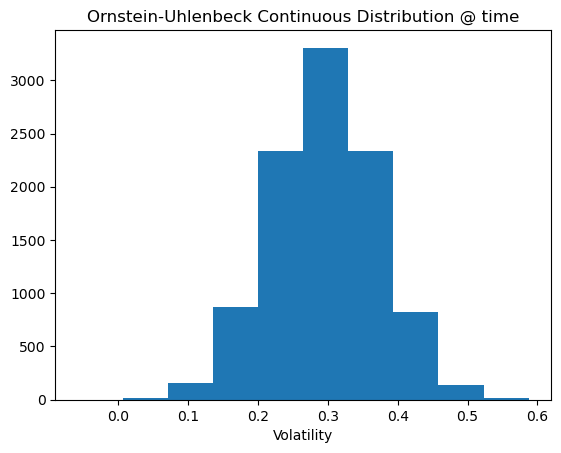

In [41]:
time = 0.2
M = 10000

Z = np.random.normal(size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, time, kappa, theta)
diffusion_OU = std(time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z

plt.hist(vol_OU)
plt.title('Ornstein-Uhlenbeck Continuous Distribution @ time')
plt.xlabel('Volatility')
plt.show()

### Discretised SDE
Euler-Maryuama discretisation (an approximation of the variance):
$\Delta x_{t+1} = \kappa(\theta-x_{t})\Delta t + \sigma\sqrt{\Delta t}\epsilon_{t}$

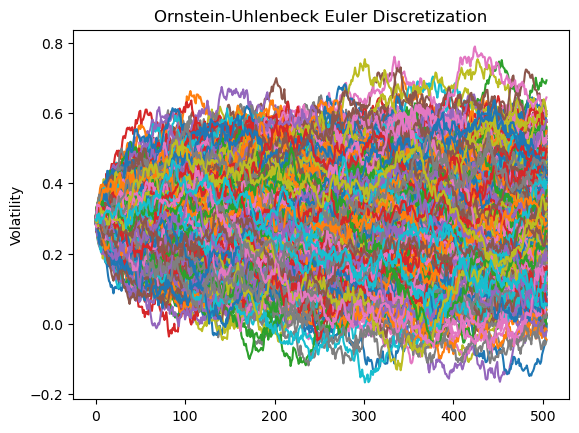

In [43]:
days = 1
years = 2

dt = days/252

M = 1000
N = int(years/dt)

vol_OU = np.full(shape=(N,M), fill_value=vol0)
Z = np.random.normal(size=(N,M))

def OU_recursive(t, vol_OU): 
    if t == N:
        return vol_OU
    else: 
        drift_OU = kappa*(theta - vol_OU[t-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
        return OU_recursive(t+1, vol_OU)
    
vol_OU = OU_recursive(0, vol_OU)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()